In [1]:
import yfinance as yf
import pandas as pd

In [24]:
import mplfinance as fplt
import talib # pip install TA-Lib

print("TA-Lib Version : {}".format(talib.__version__))
print("MPLFinance Version : {}".format(fplt.__version__))

TA-Lib Version : 0.4.28
MPLFinance Version : 0.12.10b0


In [25]:
# Example usage
symbols = [
            "AMZN",
            "ARM",
            "NVDA",
            "SMCI",
            "BSI.MU",
            "KLAC",
            "ARM",
            "QCOM",
            "AMD",
            "MSFT",
            "RDC.DE",
            "SAP",
            "BC8.DE",
            "META",
            "TSFA.F",
            "ASML",
            "GOOG",
            "BTC-USD",
            "CRM",
            "BY6.F",
            "SHL.DE",
            "DDOG",
            "MDB",
            "^GSPC",
           ]
df = yf.download(symbols, period="200d")

[*********************100%%**********************]  23 of 23 completed


In [26]:
for symbol in symbols:
    df["SMA50", symbol] = df["Adj Close", symbol].rolling(50).mean()
    df["SMA200", symbol] = df["Adj Close", symbol].rolling(200).mean()
    # df["RSI", symbol] = talib.RSI(df["Adj Close", symbol], timeperiod=3)
    df["EMA", symbol] = df["Adj Close", symbol].ewm(span=50, adjust=False).mean()
    df["Adj Daily Return", symbol] = df["Adj Close", symbol].pct_change()
    df["Cum Adj Daily Return", symbol] = df["Adj Daily Return", symbol].cumsum()

/tmp/ipykernel_703629/305460361.py:6: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipykernel_703629/305460361.py:6: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/tmp/ipykernel_703629/305460361.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_703629/305460361.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the resul

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

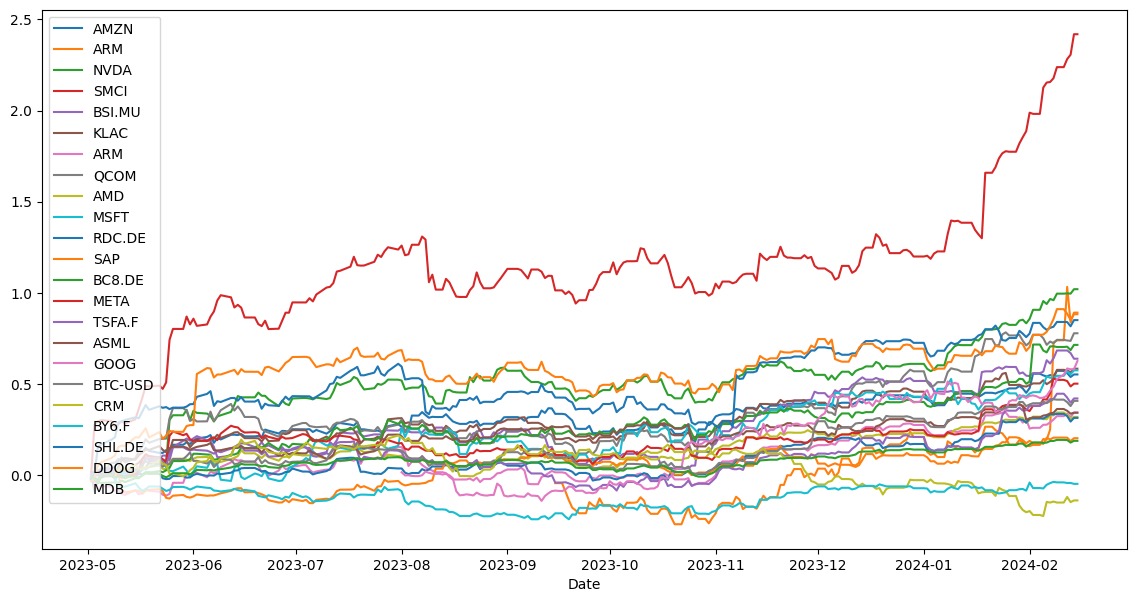

In [29]:
plt.figure(figsize=(14,7))
plt.plot(df['Cum Adj Daily Return'])
plt.xlabel('Date')
plt.legend(symbols)
plt.show()

In [16]:
import numpy as np # we will use this later, so import it now

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()


Loading BokehJS ...

In [23]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

for i in range(1, 5):
    # Calculate the date i weeks ago
    three_months_ago = datetime.today() - timedelta(days=i*7)
    # Convert the date to a string in the desired format
    date_string = three_months_ago.strftime("%Y-%m-%d")
    tmp = df[df.index >= date_string].copy()

    for symbol in symbols:
        tmp["Cum Adj Daily Return", symbol] = tmp["Adj Daily Return", symbol].cumsum()

    # Create a scatter plot
    fig = px.line(tmp['Cum Adj Daily Return'], title=f"week {i}")
    # Show the plot
    fig.show()


In [10]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

for i in (3, 6, 9, 12):
    # Calculate the date i months ago
    three_months_ago = datetime.today() - timedelta(days=i*30)
    # Convert the date to a string in the desired format
    date_string = three_months_ago.strftime("%Y-%m-%d")
    tmp = df[df.index >= date_string].copy()

    for symbol in symbols:
        tmp["Cum Adj Daily Return", symbol] = tmp["Adj Daily Return", symbol].cumsum()

    # Create a scatter plot
    fig = px.line(tmp['Cum Adj Daily Return'], title=f"month {i}")
    # Show the plot
    fig.show()


In [22]:
import itertools
import string

ticker_letters = string.ascii_uppercase

def foo(l):
     yield from itertools.product(*([l] * 3)) 

for x in foo(ticker_letters):
     # print(''.join(x))
     pass